# Distinguishing countermeasures by output

In [69]:
import io
import random
import itertools
import warnings

import cypari2
from cysignals.alarm import alarm, AlarmInterrupt

from matplotlib import pyplot as plt
from collections import Counter
from tqdm.auto import tqdm, trange

from pyecsca.misc.utils import TaskExecutor
from pyecsca.ec.mod import mod, RandomModAction
from pyecsca.ec.point import Point
from pyecsca.ec.model import ShortWeierstrassModel
from pyecsca.ec.params import load_params_ectester
from pyecsca.ec.mult import LTRMultiplier
from pyecsca.ec.context import local, DefaultContext
from pyecsca.ec.countermeasures import GroupScalarRandomization, AdditiveSplitting, MultiplicativeSplitting, EuclideanSplitting, BrumleyTuveri

%matplotlib ipympl

In [ ]:
model = ShortWeierstrassModel()
coords = model.coordinates["projective"]

In [ ]:
add = coords.formulas["add-2015-rcb"]
dbl = coords.formulas["dbl-2015-rcb"]
mult = LTRMultiplier(add, dbl, complete=False)

In [ ]:
gsr = GroupScalarRandomization(mult)
asplit = AdditiveSplitting(mult)
msplit = MultiplicativeSplitting(mult)
esplit = EuclideanSplitting(mult)
bt = BrumleyTuveri(mult)

## 3n test

In [ ]:
key3n = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006
params3n = load_params_ectester(io.BytesIO(b"0xc381bb0394f34b5ed061c9107b66974f4d0a8ec89b9fe73b98b6d1368c7d974d,0x5ca6c5ee0a10097af291a8f125303fb1a3e35e8100411902245d691e0e5cb497,0x385a5a8bb8af94721f6fd10b562606d9b9df931f7fd966e96859bb9bd7c05836,0x4616af1898b92cac0f902a9daee24bbae63571cead270467c6a7886ced421f5e,0x34e896bdb1337e0ae5960fa3389fb59c2c8d6c7dbfd9aac33a844f8f98e433ef,0x412b3e5686fbc3ca4575edb0292232702ae721a7d4a230cc170a5561aa70e00f,0x01"), "projective")
bits3n = params3n.full_order.bit_length()
point3n = Point(X=mod(0x4a48addb2e471767b7cd0f6f1d4c27fe46f4a828fc20f950bd1f72c939b36a84, params3n.curve.prime),
                Y=mod(0x13384d38c353f862832c0f067e46a3e510bb6803c20745dfb31929f4a18d890d, params3n.curve.prime),
                Z=mod(1, params3n.curve.prime), model=coords)

In [ ]:
print(f"prime:\t0x{params3n.curve.prime:x}")
print(f"a:\t0x{params3n.curve.parameters['a']:x}")
print(f"b:\t0x{params3n.curve.parameters['b']:x}")
print(f"G:\t[0x{params3n.generator.X:x},\n\t 0x{params3n.generator.Y:x}]")
print(f"n:\t0x{params3n.order:x}")
print(f"3n:\t0x{3 * params3n.order:x}")
print(f"\nP:\t[0x{point3n.X:x},\n\t 0x{point3n.Y:x}]")

In [ ]:
def generate_scalars_mod3(rem, samples):
    scalars = []
    while True:
        scalar = random.randint(0, params3n.full_order)
        if scalar % 3 == rem:
            scalars.append(scalar)
        if len(scalars) == samples:
            break
    return scalars

def test_3n(countermeasure, scalars):
    ctr = Counter()
    for k in tqdm(scalars, leave=False):
        mult.init(params3n, point3n)
        kP = mult.multiply(k).to_affine()
        mult.init(params3n, point3n)
        knP = mult.multiply(k + params3n.full_order).to_affine()
        mult.init(params3n, point3n)
        k2nP = mult.multiply(k + 2 * params3n.full_order).to_affine()

        countermeasure.init(params3n, point3n)
        res = countermeasure.multiply(k)
        aff = res.to_affine()
        if aff.equals(kP):
            ctr["k"] += 1
        elif aff.equals(knP):
            ctr["k + 1n"] += 1
        elif aff.equals(k2nP):
            ctr["k + 2n"] += 1
        else:
            ctr[aff] += 1
    for name, count in sorted(ctr.items()):
        print(f"{name}:\t{count}")

def test_3n_fixed_scalar(countermeasure, samples):
    test_3n(countermeasure, [key3n for _ in range(samples)])

def test_3n_random_scalar(countermeasure, samples):
    test_3n(countermeasure, [random.randint(0, params3n.full_order) for _ in range(samples)])

def test_3n_random_scalar_projected(countermeasure, samples):
    print("k = 0 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(0, samples))
    print()
    print("k = 1 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(1, samples))
    print()
    print("k = 2 mod 3")
    test_3n(countermeasure, generate_scalars_mod3(2, samples))

### Fixed scalar experiments

#### Group scalar randomization

In [ ]:
test_3n_fixed_scalar(gsr, 1000)

#### Additive splitting

In [ ]:
test_3n_fixed_scalar(asplit, 1000)

#### Multiplicative splitting

In [ ]:
test_3n_fixed_scalar(msplit, 1000)

#### Euclidean splitting

In [ ]:
test_3n_fixed_scalar(esplit, 1000)

#### Brumley and Tuveri bit-length fixing

In [ ]:
test_3n_fixed_scalar(bt, 1000)

### Random scalar experiments

#### Group scalar randomization

In [ ]:
test_3n_random_scalar(gsr, 1000)

#### Additive splitting

In [ ]:
test_3n_random_scalar(asplit, 1000)

#### Multiplicative splitting

In [ ]:
test_3n_random_scalar(msplit, 1000)

#### Euclidean splitting

In [ ]:
test_3n_random_scalar(esplit, 1000)

#### Brumley and Tuveri bit-length fixing

In [ ]:
test_3n_random_scalar(bt, 1000)

### Random scalar experiments projected to scalar divisor classes mod 3

#### Group scalar randomization

In [ ]:
test_3n_random_scalar_projected(gsr, 1000)

#### Additive splitting

In [ ]:
test_3n_random_scalar_projected(asplit, 1000)

#### Multiplicative splitting

In [ ]:
test_3n_random_scalar_projected(msplit, 1000)

#### Euclidean splitting

In [ ]:
test_3n_random_scalar_projected(esplit, 1000)

#### Brumley and Tuveri bit-length fixing

In [ ]:
test_3n_random_scalar_projected(bt, 1000)

## Mask recovery
Using a composite order curve we can recover the size and the actual mask values (in a known key scenario) in both GSR and multiplicative splitting. However, real-world targets do not like composite order curves and may either check the order or otherwise fail to compute on such curves. Thus, we lie to them and set the order to the next-prime of the true order, in this case $n + 92$.

In [ ]:
pari = cypari2.Pari(256_000_000, 2_000_000_000)

In [ ]:
real_n = 0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df50775
#      = 2898786277 * 2916913393 * 3067509271 * 3248233993 * 3894099889 * 4099407227 * 4101666977 * 13936975277
real_n_facts = pari.factor(real_n)
params92pn = load_params_ectester(io.BytesIO(b"0xa9fa3419aca88bade2cba14e317816c79d52481d463dc9bcb12c37f45aa3b4e1,0x2ea3bfe6659f8e035735349b91fbfa2baf0cf8e640315f0fe03c1136813dec99,0x2b07c518e04b02158651e3dbbef7720015dd496bf15af02f8439f8e1503b8370,0x90fb04b1af19e8e20396ac052f260a9fb5f736b97e3cd4af08fe81a1e75dac6d,0x2302bcf700d3d5899f04d0c7441f5017c9758bfafd6ce15dbe36fb4eea76baec,0xa9fa3419aca88bade2cba14e317816c6828910c6ce04fcd2a2e857d25df507d1,0x01"), "projective")
e = pari.ellinit([int(params92pn.curve.parameters["a"]), int(params92pn.curve.parameters["b"])], int(params92pn.curve.prime))
e[15][0] = real_n

In [ ]:
print(f"prime:\t0x{params92pn.curve.prime:x}")
print(f"a:\t0x{params92pn.curve.parameters['a']:x}")
print(f"b:\t0x{params92pn.curve.parameters['b']:x}")
print(f"G:\t[0x{params92pn.generator.X:x},\n\t 0x{params92pn.generator.Y:x}]")
print(f"n+92:\t0x{params92pn.order:x} (fake order, given to the target, prime)")
print(f"n:\t0x{real_n:x} (real order, composite)")

### Group scalar randomization
In GSR getting the mask out this way is quite simple. The target believes it is operating on a curve of order $n+92$ so it will use that value multiplied with the mask to randomize the scalar. Thus as a result we get:
$$ P = [k + r(n + 92)]G $$

However, the curve is truly of order $n$, thus arithmetic on its group will make this equal to: 
$$ P = [k + r 92]G $$

Since this is a composite order curve, we can solve the dlog and obtain $k + r 92$ and since we assume we know $k$ we can easily compute both the mask size and mask value $r$.

In [ ]:
key = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006  # any key works ofc
gsr.init(params92pn, params92pn.generator)
res = gsr.multiply(key)

In [ ]:
affine_gen = params92pn.generator.to_affine()
affine_res = res.to_affine()

In [ ]:
dlog = pari.elllog(e,
                   [int(affine_res.x), int(affine_res.y)],
                   [int(affine_gen.x), int(affine_gen.y)],
                   real_n)

In [ ]:
mask = int((dlog - key) / 92)
mask_len = mask.bit_length()
print(mask)
print(mask_len)

### Multiplicative splitting
In multiplicative splitting the situation is a bit more complicated. Doing the same computation, where the target thinks the curve order is $n+92$ leads to:
$$ P = [k r^{-1}\pmod{n+92}][r \mod n]G $$

Since the curve is composite order we can easily compute the dlog $d$ of P to G, we get:
$$ d = (k r^{-1})\pmod{n+92}\: r  = k + t (n + 92) $$

However, the dlog is computed $\mod n$ so we really get: $ d = k + t 92$. We extract the $t$ out of this.
Note that $t$ will have roughly the same size as the mask $r$, since at the left side we have $(k r^{-1}) {\mod (n+92)}$
of size $n$ and $r$ of size of the mask and on the right size we have $t n$ that dominates.
Thus at this point we have recovered the mask size.
However, $t$ is always smaller than $r$, sometimes also in bitsize.

Now that we have $s$ we can go back to the original equation and get:
$$ (k r^{-1})\pmod{n+92}\: r = k + t (n + 92) $$

We can then factor this value, lets call it $full$, and look for divisors that are larger than $t$ but smaller than the mask length
that we recovered before. There may be multiple candidates here and we don't know how to distinguish between
them. It holds for all of the candidates $c$ that the rest of the value $full$ is equal to the inverse of $c \mod (n+92)$.
However, sometimes there is only one candidate, which is equal to the true mask value $r$.

In [80]:
def divisors(primes, powers):
    for comb in itertools.product(*[range(power+1) for power in powers]):
        value = 1
        for prime, power in zip(primes, comb):
            value *= prime**power
        yield value

def pari_factor(number, flag=1+8, duration=5*60):
    # Use the 1 + 8 option to factorint to skip some costly factorization methods, we don't need the huge factors.
    # This means that some factors may remain, which in turn means that sometimes we may not find the true mask.
    pari = cypari2.Pari(256_000_000, 2_000_000_000)
    with warnings.catch_warnings(category=RuntimeWarning):
        warnings.simplefilter("ignore")
        try:
            alarm(duration)
            factors = pari.factorint(number, flag)
        except AlarmInterrupt:
            return None
    primes = list(map(int, factors[0]))
    powers = list(map(int, factors[1]))
    return primes, powers

def pari_dlog(params, P, G, real_n, facts_str):
    pari = cypari2.Pari(256_000_000, 2_000_000_000)
    e = pari.ellinit([int(params.curve.parameters["a"]), int(params.curve.parameters["b"])], int(params.curve.prime))
    e[15][0] = real_n
    facts = pari(facts_str)
    dlog = pari.elllog(e, P, G, facts)
    return int(dlog)

In [81]:
key = 0x20959f2b437de1e522baf6d814911938157390d3ea5118660b852ab0d5387006  # any key works
msplit = MultiplicativeSplitting(mult, rand_bits=32)  # change the mask size here to your liking
tries = 1000
num_workers = 30

blens = [None for _ in range(tries)]
dlogs = [None for _ in range(tries)]
ts = [None for _ in range(tries)]

results = [None for _ in range(tries)]
rs = [None for _ in range(tries)]

with TaskExecutor(max_workers=num_workers) as pool:
    for i in trange(tries, desc="Collecting scalarmults"):
        msplit.init(params92pn, params92pn.generator)
        with local(DefaultContext()) as ctx:
            res = msplit.multiply(key)
    
        affine_res = res.to_affine()
        affine_gen = params92pn.generator.to_affine()
        results[i] = affine_res
        
        rval = []
        ctx.actions[0].walk(lambda action: rval.append(int(action.result)) if isinstance(action, RandomModAction) else None)
        rs[i] = rval[0]
        
        pool.submit_task(i,
                         pari_dlog,
                         params92pn,
                         [int(affine_res.x), int(affine_res.y)],
                         [int(affine_gen.x), int(affine_gen.y)],
                         real_n,
                         repr(real_n_facts))
    
    for i, future in tqdm(pool.as_completed(), desc="Computing dlogs", total=len(pool.tasks)):
        dlog = future.result()
        val = dlog - key
        if val % 92 != 0:
            print(f"Bad val! {i}")
        t = val // 92
        ts[i] = t
        dlogs[i] = dlog
        blens[i] = t.bit_length()

mask_len = max(blens)
print(mask_len, mask_len == msplit.rand_bits)

Computing dlogs:   0%|          | 0/1000 [00:00<?, ?it/s]

32 True


In [85]:
with TaskExecutor(max_workers=num_workers) as pool:
    fulls = []
    for t in ts:
        full = t * (real_n + 92) + key
        fulls.append(full)
        pool.submit_task(t,
                         pari_factor,
                         full, flag=0)
    facts = [None for _ in ts]
    for t, future in tqdm(pool.as_completed(), desc="Factoring", total=len(ts)):
        result = future.result()
        if result is None:
            print("Timed out.")
        facts[ts.index(t)] = result

Factoring:   0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
candidate_amounts = []
i = 0
for dlog, t, blen, r, fact, full, result in zip(dlogs, ts, blens, rs, facts, fulls, results):
    if fact is None:
        continue
    
    (primes, powers) = fact
    complete = True
    for prime in primes:
        if not pari.isprime(prime):
            complete = False
            break

    i += 1
    candidates = set()
    for divisor in divisors(primes, powers):
        if divisor.bit_length() <= mask_len and divisor >= t:
            candidates.add(divisor)
    candidate_amounts.append(len(candidates))
    if len(candidates) == 1:
        candidate = candidates.pop()
        print("Only one candidate, we got the mask:", candidate, candidate == r, "incomplete factoring this may not be the r" if not complete else "")
print(f"Total recovered masks: {len(list(filter(lambda a: a == 1, candidate_amounts)))} out of {i}")

Only one candidate, we got the mask: 2842006421 True 
Only one candidate, we got the mask: 1367232818 True 
Only one candidate, we got the mask: 2240904829 True 
Only one candidate, we got the mask: 1039351451 True 
Only one candidate, we got the mask: 108996955 True 
Only one candidate, we got the mask: 2881524907 True 
Only one candidate, we got the mask: 2189838553 True 
Only one candidate, we got the mask: 3969096149 True 
Only one candidate, we got the mask: 2287426132 True 
Only one candidate, we got the mask: 4074964099 True 
Only one candidate, we got the mask: 2669990606 True 
Only one candidate, we got the mask: 1456246563 True 
Only one candidate, we got the mask: 2710951939 True 
Only one candidate, we got the mask: 2825913889 True 
Only one candidate, we got the mask: 1638243357 True 
Only one candidate, we got the mask: 3811276388 True 
Only one candidate, we got the mask: 3123140239 True 
Only one candidate, we got the mask: 3595726430 True 
Only one candidate, we got th

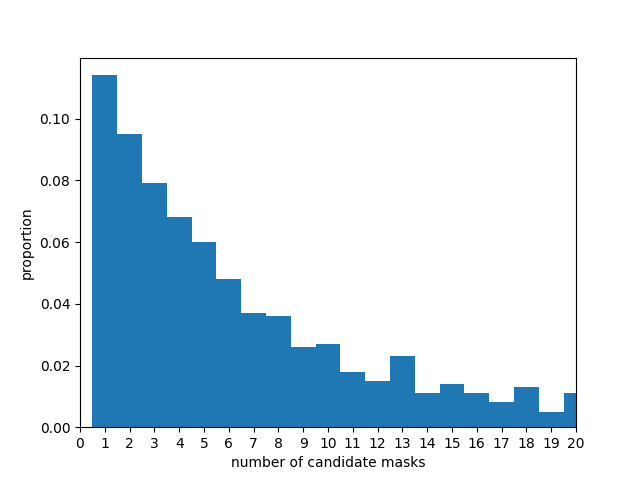

In [89]:
max_amount = max(candidate_amounts)
fig = plt.subplots()
plt.hist(candidate_amounts, range=(1, max_amount), align="left", density=True, bins=range(1, max_amount))#, bins=list(range(20)) + list(range(20, 100, 5)) + list(range(100, max(candidate_amounts), 10)))
plt.xlabel("number of candidate masks")
plt.ylabel("proportion")
plt.xticks(range(max_amount))
plt.xlim(0, 20);
plt.show()

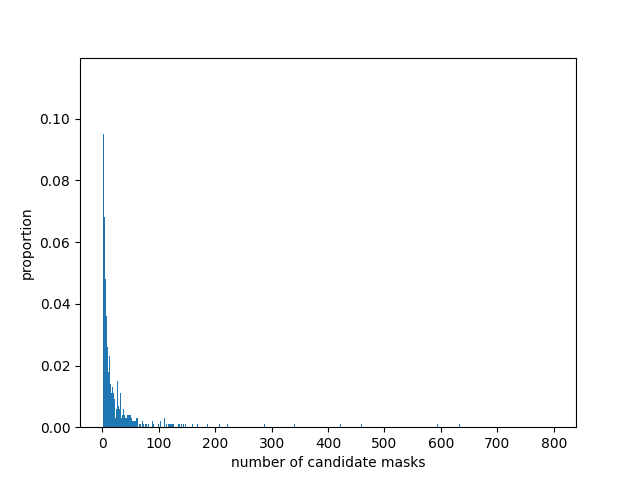

In [90]:
max_amount = max(candidate_amounts)
fig = plt.subplots()
plt.hist(candidate_amounts, range=(1, max_amount), align="left", density=True, bins=range(1, max_amount))#, bins=list(range(20)) + list(range(20, 100, 5)) + list(range(100, max(candidate_amounts), 10)))
plt.xlabel("number of candidate masks")
plt.ylabel("proportion")
plt.show()